# Healthcare Risk Assessment System – Setup Instructions

Before running this notebook, please complete the following steps:

## 1 Install Ollama
Download and install Ollama from:
https://ollama.com/download

After installation, verify:
ollama --version

---

## 2️ Pull the Required Model
We use Llama 3.1 (8B). Run:
ollama pull llama3.1:8b

Wait until the download finishes.

---

## 3️ Start Ollama Server
Before running the notebook, start the Ollama server:
ollama serve

Keep this terminal open while executing the notebook.

---

## 4️ Install Required Python Libraries
In your project folder, run:
pip install langchain langchain-ollama langgraph

(Or inside a notebook cell: !pip install langchain langchain-ollama langgraph)

---

## 5️ Run the Notebook
After completing all steps:
- Ensure Ollama is running
- Execute all notebook cells
- Test using different patient_input examples

This system is for educational and research purposes only.
It is NOT a real clinical diagnostic tool.

In [104]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from typing import TypedDict



In [105]:
class HealthState(TypedDict):
    patient_input: str
    vitals_validation: str
    risk_classification: str
    clinical_advice: str

In [106]:
llm = ChatOllama(
    model="llama3.1:8b",
    temperature=0
)

In [107]:
import re

def vitals_sanity_agent(state: HealthState) -> HealthState:
    text = state["patient_input"]

    try:
        hr_match = re.search(r"Heart Rate:\s*(\d+)", text)
        bp_match = re.search(r"Systolic BP:\s*(\d+)", text)
        spo2_match = re.search(r"Oxygen Saturation:\s*(\d+)", text)
        temp_match = re.search(r"Temperature:\s*([\d.]+)", text)

        if not hr_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Heart Rate."
            }

        if not bp_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Systolic BP."
            }

        if not spo2_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Oxygen Saturation."
            }

        if not temp_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Temperature."
            }

        hr = int(hr_match.group(1))
        bp = int(bp_match.group(1))
        spo2 = int(spo2_match.group(1))
        temp = float(temp_match.group(1))

    except Exception:
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Unable to parse vital values."
        }

    # Strict numeric boundaries
    if not (30 <= hr <= 220):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Heart Rate is outside allowed range (30–220 bpm)."
        }

    if not (50 <= bp <= 250):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Systolic BP is outside allowed range (50–250 mmHg)."
        }

    if not (50 <= spo2 <= 100):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Oxygen Saturation is outside allowed range (50–100%)."
        }

    if not (30 <= temp <= 45):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Temperature is outside allowed range (30–45 °C)."
        }

    # If everything passes
    return {
        "patient_input": text,
        "vitals_validation": "VALID"
    }

In [108]:
def risk_classification_agent(state: HealthState) -> HealthState:
    
    # Safety Gate: Do not classify if vitals are invalid
    if "INVALID" in state["vitals_validation"]:
        return {
            "patient_input": state["patient_input"],
            "vitals_validation": state["vitals_validation"],
            "risk_classification": "Cannot classify due to invalid vitals"
        }

    system_prompt = """
You are a medical risk classification agent.

Your task:
- Classify patient condition into exactly ONE of the following labels:

Stable
Moderate Risk
Critical

Base your decision ONLY on:
- Heart Rate
- Systolic Blood Pressure
- Oxygen Saturation
- Temperature

Do NOT validate values.
Do NOT give treatment advice.
Do NOT invent new labels.

Output EXACTLY one of:
Stable
Moderate Risk
Critical

---

### Few-Shot Examples

Example 1:
Heart Rate: 72 bpm
Systolic BP: 118 mmHg
Oxygen Saturation: 99 %
Temperature: 36.7 °C
Risk: Stable

Example 2:
Heart Rate: 80 bpm
Systolic BP: 125 mmHg
Oxygen Saturation: 97 %
Temperature: 37.0 °C
Risk: Stable

Example 3:
Heart Rate: 65 bpm
Systolic BP: 110 mmHg
Oxygen Saturation: 98 %
Temperature: 36.5 °C
Risk: Stable

Example 4:
Heart Rate: 88 bpm
Systolic BP: 130 mmHg
Oxygen Saturation: 96 %
Temperature: 37.2 °C
Risk: Stable

Example 5:
Heart Rate: 75 bpm
Systolic BP: 115 mmHg
Oxygen Saturation: 97 %
Temperature: 36.9 °C
Risk: Stable

Example 6:
Heart Rate: 110 bpm
Systolic BP: 100 mmHg
Oxygen Saturation: 93 %
Temperature: 38.2 °C
Risk: Moderate Risk

Example 7:
Heart Rate: 120 bpm
Systolic BP: 95 mmHg
Oxygen Saturation: 92 %
Temperature: 38.5 °C
Risk: Moderate Risk

Example 8:
Heart Rate: 105 bpm
Systolic BP: 105 mmHg
Oxygen Saturation: 94 %
Temperature: 37.8 °C
Risk: Moderate Risk

Example 9:
Heart Rate: 98 bpm
Systolic BP: 90 mmHg
Oxygen Saturation: 91 %
Temperature: 38.0 °C
Risk: Moderate Risk

Example 10:
Heart Rate: 115 bpm
Systolic BP: 92 mmHg
Oxygen Saturation: 93 %
Temperature: 39.0 °C
Risk: Moderate Risk

Example 11:
Heart Rate: 150 bpm
Systolic BP: 75 mmHg
Oxygen Saturation: 85 %
Temperature: 39.5 °C
Risk: Critical

Example 12:
Heart Rate: 165 bpm
Systolic BP: 70 mmHg
Oxygen Saturation: 82 %
Temperature: 40.0 °C
Risk: Critical

Example 13:
Heart Rate: 45 bpm
Systolic BP: 80 mmHg
Oxygen Saturation: 84 %
Temperature: 35.0 °C
Risk: Critical

Example 14:
Heart Rate: 140 bpm
Systolic BP: 65 mmHg
Oxygen Saturation: 88 %
Temperature: 40.5 °C
Risk: Critical

---

### Patient Vitals:
"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["patient_input"])
    ]

    response = llm.invoke(messages)

    return {
        "patient_input": state["patient_input"],
        "vitals_validation": state["vitals_validation"],
        "risk_classification": response.content.strip()
    }

In [109]:
def clinical_advice_agent(state: HealthState) -> HealthState:
    
    # Safety Gate: If vitals invalid
    if "INVALID" in state["vitals_validation"]:
        return {
            "patient_input": state["patient_input"],
            "vitals_validation": state["vitals_validation"],
            "risk_classification": state["risk_classification"],
            "clinical_advice": "Vitals are invalid. Please recheck measurements before clinical interpretation."
        }

    system_prompt = """
You are a medical advisory agent.

Your task:
- Provide short, clear clinical guidance based ONLY on the risk classification.
- Use simple, non-technical language.
- Keep response concise (2-3 sentences maximum).

Rules:
- If Risk is Stable → reassure and suggest routine monitoring.
- If Risk is Moderate Risk → suggest closer observation and possible evaluation.
- If Risk is Critical → recommend immediate medical attention or escalation.

Do NOT:
- Reclassify risk
- Validate vitals
- Mention internal reasoning
- Provide medication names
- Provide dosage instructions

Keep advice general and safe.
"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(
            content=f"""
Patient Vitals:
{state['patient_input']}

Risk Classification:
{state['risk_classification']}
"""
        )
    ]

    response = llm.invoke(messages)

    return {
        "patient_input": state["patient_input"],
        "vitals_validation": state["vitals_validation"],
        "risk_classification": state["risk_classification"],
        "clinical_advice": response.content.strip()
    }

In [110]:
workflow = StateGraph(HealthState)

workflow.add_node("vitals_sanity_check", vitals_sanity_agent)
workflow.add_node("risk_classification", risk_classification_agent)
workflow.add_node("clinical_advice", clinical_advice_agent)

workflow.add_edge(START, "vitals_sanity_check")
workflow.add_edge("vitals_sanity_check", "risk_classification")
workflow.add_edge("risk_classification", "clinical_advice")
workflow.add_edge("clinical_advice", END)

app = workflow.compile()

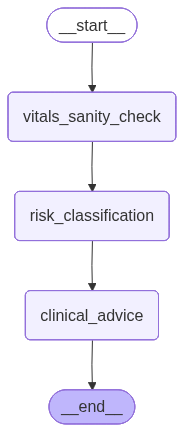

In [111]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))


In [112]:
def format_final_output(result: dict):
    print("=" * 60)
    print("PATIENT RISK ASSESSMENT REPORT")
    print("=" * 60)

    print("\nVITALS SANITY CHECK")
    print(result["vitals_validation"])

    print("\nRISK CLASSIFICATION")
    print(result["risk_classification"])

    print("\nCLINICAL ADVICE")
    print(result["clinical_advice"])

    print("\nFINAL VERDICT")

    if "INVALID" in result["vitals_validation"]:
        print("Assessment cannot proceed due to invalid vital measurements.")

    elif result["risk_classification"] == "Critical":
        print("Patient condition is CRITICAL. Immediate medical attention required.")

    elif result["risk_classification"] == "Moderate Risk":
        print("Patient condition is concerning. Close monitoring is advised.")

    elif result["risk_classification"] == "Stable":
        print("Patient condition appears stable. Continue routine observation.")

    else:
        print("Unable to determine final verdict.")

    print("=" * 60)

In [113]:
patient_input = """
Heart Rate: 90 bpm
Systolic BP: 120 mmHg
Oxygen Saturation: 96 %
Temperature: 50.0 °C
"""

In [114]:
result = app.invoke(
    {"patient_input": patient_input}
)

format_final_output(result)

PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
INVALID: Temperature is outside allowed range (30–45 °C).

RISK CLASSIFICATION
Cannot classify due to invalid vitals

CLINICAL ADVICE
Vitals are invalid. Please recheck measurements before clinical interpretation.

FINAL VERDICT
Assessment cannot proceed due to invalid vital measurements.


In [115]:
patient_input = """
Heart Rate: 72 bpm
Systolic BP: 118 mmHg
Oxygen Saturation: 99 %
Temperature: 36.7 °C
"""

result = app.invoke({"patient_input": patient_input})
format_final_output(result)

PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
VALID

RISK CLASSIFICATION
Stable

CLINICAL ADVICE
The patient's risk is stable, so routine monitoring is recommended to ensure no changes occur. Continue with current care and schedule a follow-up appointment as planned.

FINAL VERDICT
Patient condition appears stable. Continue routine observation.


In [116]:
patient_input = """
Heart Rate: 200 bpm
Systolic BP: 70 mmHg
Oxygen Saturation: 85 %
Temperature: 40.0 °C
"""

result = app.invoke({"patient_input": patient_input})
format_final_output(result)

PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
VALID

RISK CLASSIFICATION
Critical

CLINICAL ADVICE
Immediate medical attention is required due to severe tachycardia, hypotension, and potential respiratory distress. The patient's condition is life-threatening and requires urgent evaluation and treatment. Call emergency services or transfer the patient to a critical care unit immediately.

FINAL VERDICT
Patient condition is CRITICAL. Immediate medical attention required.


In [117]:
patient_input = """
Heart Rate: 117 bpm
Systolic BP: 95 mmHg
Oxygen Saturation: 92 %
Temperature: 38.8 °C
"""

result = app.invoke({"patient_input": patient_input})
format_final_output(result)

PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
VALID

RISK CLASSIFICATION
Moderate Risk

CLINICAL ADVICE
Monitor the patient closely for signs of worsening condition, such as increased shortness of breath or decreased oxygen saturation. Consider evaluating the patient with a physical exam and possibly ordering additional tests to determine the cause of their symptoms. Keep them hydrated and comfortable until further evaluation can be done.

FINAL VERDICT
Patient condition is concerning. Close monitoring is advised.
